Plot the DWI signal covariance on an HCP participant data and compare it to the exponential and spherical covariance models.

Load data corresponding to the $b=3000$ shell of an HCP participant. 

In [1]:
from pathlib import Path

import numpy as np
import nibabel as nib

from eddymotion.model.dmri_utils import (
    find_shelling_scheme,
)

path = Path("/data/hcp")
dwi_fname = path / "data.nii.gz"
brain_mask_fname = path / "nodif_brain_mask.nii.gz"
bvals_fname = path / "bvals"
bvecs_fname = path / "bvecs"

bvals = np.loadtxt(bvals_fname)
scheme, bval_groups, bval_estimated = find_shelling_scheme(bvals)

bvals_b3k = bval_groups[-1]
b3k_mask = np.isin(bvals, bvals_b3k)
b3k_ngrads = sum(b3k_mask)

bvecs = np.loadtxt(bvecs_fname)
bvecs_b3k = bvecs[:, b3k_mask]

dwi = nib.load(dwi_fname)
dwi_data = dwi.get_fdata()
dwi3k_data = dwi_data[..., b3k_mask]

# Load the brain mask in order to consider only the brain voxels when computing the covariance
brain_mask = nib.load(brain_mask_fname)
brain_mask_data = brain_mask.get_fdata()

Compute the pairwise angles across the shell diffusion-encoding gradient vectors.

In [2]:
from eddymotion.model.dipy import compute_pairwise_angles

closest_polarity = True
_theta = compute_pairwise_angles(bvecs_b3k, closest_polarity=closest_polarity)
theta_data = _theta[0, :]

Compute the covariance for each pair of gradient-encoding diffusion vectors across all intra-cerebral voxels.

In [3]:
bias = True  # normalization factor: N-1 if False; N if True
_cov = np.asarray([
    np.cov(
        dwi3k_data[..., grad_idx1][np.where(brain_mask_data)].flatten(),
        dwi3k_data[..., grad_idx2][np.where(brain_mask_data)].flatten(),
        bias=bias,
    )[0, 1]
    # statistics.covariance(x, y) should give the same answer as above
    for grad_idx1 in range(b3k_ngrads)
    for grad_idx2 in range(b3k_ngrads)
])

# Normalize
_cov = _cov / np.max(_cov)

# Reshape to have each the covariance values corresponding to each bvec pair grouped
cov = np.asarray(_cov).reshape((b3k_ngrads, b3k_ngrads))

Compute the exponential and the spherical covariance function matrix values for angles between $0$ and $\pi/2$. The length scale parameters are set to $a=1.23$ and $a=0.5$ for the spherical and the exponential functions respectively.

In [4]:
import numpy as np

from eddymotion.model.dipy import (
    compute_exponential_covariance,
    compute_spherical_covariance,
)

theta_lin = np.linspace(0, np.pi/2, num=1000)

a_exp = 0.5
cov_exp = compute_exponential_covariance(theta_lin, a_exp)

a_sph = 1.23
cov_sph = compute_spherical_covariance(theta_lin, a_sph)

The empirically observed covariance versus angle between diffusion weighting directions (b-vectors) for the HCP $b=3000$ shell. Each point represents one pair of b-vectors and the covariance is calculated across all intra-cerebral voxels. The points with zero angle corresponds to the variance (pooled across all voxels) for each direction.

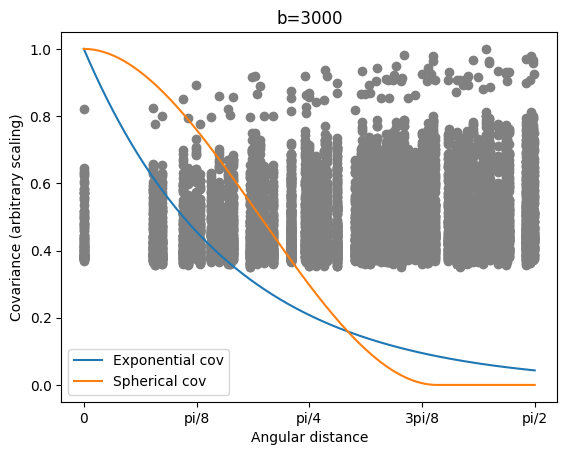

In [5]:
import matplotlib.pyplot as plt

# Plot the exponential and spherical model covariances
plt.plot(theta_lin, cov_exp, label="Exponential cov")
plt.plot(theta_lin, cov_sph, label="Spherical cov")

# Plot the covariances computed from the data
# ToDo
# The points with zero angle corresponds to the variance (pooled across all voxels) for each direction.
for i in range(b3k_ngrads):
    plt.scatter(theta_data, cov[i], c="gray")

plt.xticks([0.0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2], ["0", "pi/8", "pi/4", "3pi/8", "pi/2"])

plt.title("b=3000")
plt.xlabel("Angular distance")
plt.ylabel("Covariance (arbitrary scaling)")

plt.legend()
plt.show()